# Hands-on Machine Learning

## Session 7: Deep Learning

by Daniel Bug

### Goal of this session

In this session you will:
* implement a deep neural network
* learn about different layer types and activation functions
* experiment with visualization techniques

Mind that there are still a few things we hide behind the scenes:
* Data Loading / Handling is done using framework utilities (see additional python scripts and pytorch doc)
* Data Augmentation will be covered in a later session

### Dataset

This session uses the PascalVOC dataset, which is accessible on this server.
The dataset comprises input images that can be classified with different strategies.
We consider an image classification problem, i.e. decide which objects from a finite set of classes appear in the input image.
Since multiple objects may appear in each image, this is a multi-label classification task.

Let's dive right into the task:
Make sure to run the imports and continue loading the dataset to RAM.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Set this parameter to YOUR GROUP NUMBER

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import voc as dsetVOC
import torchvision.transforms as standard_transforms
import transforms as extended_transforms

from torch.autograd import Variable
from torch.utils.data import DataLoader

#### Loading the dataset

We prepared a loader for you that can automatically grab a training- and testset.
Run the cell below a few times to get an overview of the data available.

You can print the cls2lbl dictionary to see the list of all classes.


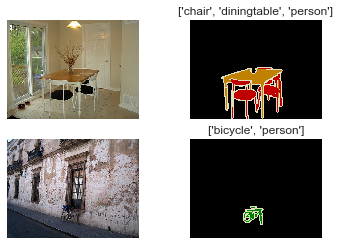

In [64]:
train_set = dsetVOC.VOC('train')
valid_set = dsetVOC.VOC('valid')
cls2lbl = dsetVOC.class_to_label

for i in range(2):
    img, mask, classes = valid_set.__getitem__(np.random.randint(0, 100 + 1), colorize=True)
    plt.subplot(2,2,2*i+1)
    plt.imshow(img)
    plt.xticks(()); plt.yticks(())
    plt.subplot(2,2,2*i+2)
    plt.imshow(mask)
    plt.xticks(()); plt.yticks(())
    plt.title(str([cls2lbl[x+1] for x in np.where(classes>0.)[0]]))
plt.show()

## Building a network

### Defining functional units

As introduced in the preparation, we are going to implement a VGGNet model as a classifier.
From the previous session you know the setup of classical Multilayer Perceptrons.

**Q1a:** Which other layer types appear in the VGG architecture?

The VGG architecture has a rather simple structure

**Q1b:** How can a VGG net be structured in small functional units (3-4 layers)?

#### ... write your answers/ideas in this box

The blocks of the VGGNet should look like this:
![Blockstructure](vgg16block-structure.png "Blockstructure")
Note that this structure is a little bit different from the original architecture. and reflects some recent advances in Deep Learning

**TASK** Implement the function below:

*Hint:* implement a functional block by defining a new python class which inherits from nn.Module (see pytorch doc).
You have to write an *init* and *forward* method. 

In [3]:
class VGGBlock(nn.Module):
    def __init__(self, ifeat, ofeat, N=2):
        super(VGGBlock, self).__init__()
        assert(N in (2, 3))
        
        # setup all layers inside a VGG block here
        
    def forward(self, x):
        
        # define the forward method,  note that there are 2 or 3 convolution layers


### Main Architecture

The standard VGG Net is used to predict a single class. Recall that in PascalVOC multiple objects may be present in an image.

**Q2:** What changes between a single and multi-label scenario?

#### ... write your answers/ideas in this box

Since the number of classes in PascalVOC is much smaller than in the ILSCVR Challenge (where VGG16 was benchmarked) the number of parameters for the Linear Layers can drastically be reduced in this session. Use _1024_ instead of _4096_ parameters.

**TASK** Using the block diagram in the preparation and your pytorch module above, implement a VGG-16 network as nn.Module.

In [4]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        
        # set up the blocks for the feature extractor part
        self.block1 = VGGBlock(3, 64)
        self.block2 = # ... your part
        # ...
        
        k = # size of the feature plane after the extractor
        
        # set up the dense layers here, this is the classifier part of the network
        # don't forget the Dropout for a better learning behaviour
        # ... your part

    def forward(self, x):
        # implement the forward function
        
        # print(x.size())  # useful for finding the 'k' above
        x = x.view(x.size(0), -1)  # this call of view transforms the 2D feature field into a vector

        # implement the classifier function
        
        return x

### Data Preparation

This part covers necessary preparations to use the images from PascalVOC in the training process.
Read through the implementations below and using the pytorch doc explore what is done here.

In [5]:
def get_data_loaders():
    mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    inp_transform = standard_transforms.Compose([
        standard_transforms.Pad(300),
        standard_transforms.CenterCrop(500),
        standard_transforms.Resize(320),
        standard_transforms.RandomHorizontalFlip(),  # We can include this here, since we don't use the masks anyways.
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])

    tgt_transform = standard_transforms.Compose([
        standard_transforms.Pad(300),
        standard_transforms.CenterCrop(500),
        standard_transforms.Resize(320),
        standard_transforms.ToTensor()])

    train_set = dsetVOC.VOC('train', transform=inp_transform, target_transform=tgt_transform)
    valid_set = dsetVOC.VOC('valid', transform=inp_transform, target_transform=tgt_transform)

    train_loader = DataLoader(train_set, batch_size=16, num_workers=4, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=1, num_workers=4, shuffle=False)
    
    return train_loader, valid_loader

## Training Loop

**Q3:** How is the training process structured? Which steps form an epoch?

#### ... write your answers/ideas in this box

**TASK** Implement a training loop for the VGG16 model.
In PyTorch you need to set up model, loss function and optimizer. This is done as initialization before entering the loop.
During trainig we iterate multiple times through the dataset until the loss is not reduced any further.
Iteration in mini-batches is necessary since using the entire dataset at once would largely exceed the GPUs memory capacity.

For an improved estimation of the actual performance we iterate over the validation data as well (*Recap* session on unbiased evaluation).

In [24]:
network = VGG16()

# send the network to the GPU
# initialize your loss criterion
# initialize an optimizer object

train_loader, valid_loader = get_data_loaders()

for epoch in range(11):
    
    network.train(True)
    ep_train_losses = []
    for batch_nr, data in enumerate(train_loader):
        # get the required data and labels and wrap them in variables for the GPU processing
        # ...
        
        # (optional) write some visualization to check if it works
        # ...
        
        # compute a loss from the network output
        # ...
        
        # ...  # zero old gradient values
        # ...  # compute new gradients
        # ...  # update weights
        
        # write some updating output for the current loss
        # ...

    
    network.train(False)
    ep_valid_losses = []
    for batch_nr, data in enumerate(valid_loader):
        # repeat the steps above for the validation set
        # which steps have to be skipped?


# save your trained model
# ...



0 mean 68.90873
10 mean 43.89384
20 mean 35.98329
30 mean 32.64599
40 mean 30.80989
50 mean 29.69131
60 mean 28.95249
70 mean 28.26188
80 mean 27.66852
90 mean 27.12202
100 mean 26.86626
110 mean 26.58412
120 mean 26.36404
130 mean 26.17168
140 mean 26.01170
150 mean 25.73826
160 mean 25.55255
170 mean 25.37973
180 mean 25.22323
190 mean 25.03943
200 mean 24.86927
210 mean 24.84402
220 mean 24.76189
230 mean 24.62264
240 mean 24.54412
250 mean 24.44043
260 mean 24.36207
270 mean 24.28438
280 mean 24.22396
290 mean 24.17091
300 mean 24.11794
310 mean 24.02861
320 mean 23.99928
330 mean 23.98583
340 mean 23.93796
350 mean 23.87929
360 mean 23.84981
370 mean 23.78601
380 mean 23.72546
390 mean 23.70863
400 mean 23.67311
410 mean 23.63153
420 mean 23.58733
430 mean 23.57075
440 mean 23.53992
450 mean 23.50016
460 mean 23.49957
470 mean 23.43224
480 mean 23.41868
490 mean 23.38157
500 mean 23.33412
510 mean 23.31191
520 mean 23.28306
530 mean 23.24702
Validation 0 mean 30.14898 std 12.64918

110 mean 16.74294
120 mean 16.81440
130 mean 16.77936
140 mean 16.73207
150 mean 16.75075
160 mean 16.79588
170 mean 16.73947
180 mean 16.77212
190 mean 16.66744
200 mean 16.69849
210 mean 16.74494
220 mean 16.75164
230 mean 16.71564
240 mean 16.71664
250 mean 16.72818
260 mean 16.76569
270 mean 16.77150
280 mean 16.76195
290 mean 16.74893
300 mean 16.76196
310 mean 16.74464
320 mean 16.71159
330 mean 16.74942
340 mean 16.73473
350 mean 16.72276
360 mean 16.75437
370 mean 16.76237
380 mean 16.76084
390 mean 16.74063
400 mean 16.71380
410 mean 16.71724
420 mean 16.72765
430 mean 16.77288
440 mean 16.77629
450 mean 16.77545
460 mean 16.78106
470 mean 16.79043
480 mean 16.82189
490 mean 16.80589
500 mean 16.81447
510 mean 16.82879
520 mean 16.83472
530 mean 16.86481
Validation 8 mean 25.33984 std 10.83045
0 mean 18.03937
10 mean 17.54690
20 mean 16.60055
30 mean 16.40761
40 mean 16.86160
50 mean 16.78564
60 mean 16.40138
70 mean 16.36290
80 mean 16.24824
90 mean 16.23241
100 mean 16.33748

D:\anac36\lib\site-packages\torch\serialization.py:158: UserWarning: Couldn't retrieve source code for container of type VGG16. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\anac36\lib\site-packages\torch\serialization.py:158: UserWarning: Couldn't retrieve source code for container of type VGGBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Visualize some examples

Verification is important! To assess the quality of the model we have to find suitable measures to quantify the results for our test and validation data (ideally in a way we can easily understand), but more often than not, it will help tremendously to simply browse through some examples and verify the model by manual inspection.

In [1]:
network = torch.load('./model_ep10_adam.pth')
network.train(False)

_, browse_loader = get_data_loaders()
cls2lbl = dsetVOC.class_to_label

num_labels = 1e-12
top_5_scores = []
top_1_scores = []
myscore = [ [] for i in range(5) ]
for img_nr, data in enumerate(browse_loader):
    imgs, _, lbls = data

    inputs = Variable(imgs).cuda()
    output = torch.sigmoid(network(inputs))
    prediction = np.squeeze(output.cpu().data.numpy())
    args = np.argsort(prediction)
    top5 = np.argsort(prediction)[-5:]
    top1 = np.argsort(prediction)[-1]
    
    labels = lbls.numpy()[0]
        
    # implementation top5 error
    top_5_score = 0
    for ll in np.where(labels>0)[0]:
        if ll in top5:
            top_5_score += 1
    top_5_score = top_5_score/np.sum(labels)
    top_5_scores.append(top_5_score)
    
    # Implement your on error measure
    # ...

        
print('Top 5 score: {:.2f}%'.format(100*np.mean(top_5_scores)))
# Print your on error measure
# ...


NameError: name 'torch' is not defined

### Top-N Accuracy

Extend the above computation by implementing a Top-5 error measure, i.e. we score whenever a label we expect from the ground-truth appears in our Top-5 predictions.

**Statement:** The Top-5 error is a fair measure for this evaluation.

**Q4:** Think, discuss, reason.

**Q5:** Suggest and implement your own idea to compute a human interpretable score for the network performance.

#### ... write your answers/ideas in this box

We hope you enjoyed the session! - Feel free to give your feedback and help us improve this lab...

#### ... your ideas for a improvements, peace and a better world in general, here pls :D